# Tratamiento de anomalías con distintos filtros de imágenes.

## Introducción
En este trabajo se repasan diferentes filtros útiles para la eliminación de anomalías en imágenes: Filtro por promedio, filtro gausiano y filtro de mediana. En el trabajo se usan imágenes con aomalías debido a ruido _sal y pimienta_ y ruido _gausiano_, también se usa una imagen de control que se usará para ejemplificar que efecto tiene el filtro sobre cualquier imagen.

También se inspecciona la diferencia de tratar una determinada anomalía con un tipo de filtro en particular y finalmente se ejemplifica la diferencia entre distintas implementaciones de un filtro.

Cada una de las explicaciones en este texto son traducción libre del libro Digital Image Processing de D. Sundararajan, capítulos 2.4.1, 2.4.2 y 4.3. El código presentado se escribió basado en la documentación oficial de las librerías utilizadas a lo largo del texto.

## Librerías a utilizar
En la presente trabajo se usarán las librerías OpenCV para el procesamiento de imágenes y Numpy para manejar las imágenes como si fueran arreglos bidimensionales.

In [1]:
import cv2 as cv
import numpy as np

La librería matplotlib será usada para presentar las imágenes dentro del notebook de python. Esta librería espera imágenes RGB de otra manera los tonos y colores serán distintos. Para ver las imágenes de salida con detalle es necesario ir a la carpeta `out`. Las imágenes de entrada se encuentran en la carpeta `im`.

In [2]:
from matplotlib import pyplot as plt

## Carga de imágenes

Aunque se deja en el código un mayor número de imágenes de prueba, en este trabajo usaremos tres imágenes base:
    
1. `unir-1.jpg`: Es la imagen que servirá como control. No tiene anomalías aparentes.
2. `salt-pepper-1.png`: Esta imagen es obtenida de internet, tiene ruido conocido como _sal y pimienta_.
3. `noisy-1.jpg`: Esta es una imagen antigua tomada en 2008 con una cámara Nikon, el ruido que presenta lo supondremos como _gausiano_.

Por medio de los comentarios en el código es posible cambiar las rutas fácilmente y hacer otras pruebas.

In [3]:
image_unir = cv.imread('im/unir-1.jpg')
image_snp = cv.imread('im/salt-pepper-1.png')
image_noisy = cv.imread('im/noisy-1.jpg')

## Filtro de convolución por promedio

En un filtro de convolución por promedio, el sistema pasa fácilmente los componentes de baja frecuencia de la señal y suprime los componentes de alta frecuencia. Cuando se aplica a una imagen, reemplaza cada píxel en la entrada por el promedio de los valores de un conjunto de sus píxeles vecinos [...] Las anomalías se suavizan debido al promedio. La borrosidad aumentará proporcionalmente con filtros más grandes. Este filtro es separable. Multiplicando el filtro de columna con el filtro de fila, que es la transposición del filtro de columna, obtenemos el filtro promedio.(cite https://doi.org/10.1007/978-981-10-6113-4 cap. 2.4.2)

Para usar este filtro primero es necesario crear una función que genere rápidamente una máscara de tamaño nxn. Está máscara es un arreglo con valores 1 y será multiplicado por un escalar que permita obtener el promedio.

In [4]:
def mask(n):
    '''Define a nxn mask.
    Useful for a quick filter
    '''
    mask = np.ones((n,n), np.float32)*(1/(n**2))
    return mask
# Obtener una máscara particular de tamaño 5x5
kernel = mask(5)
print(kernel)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Ahora se debe probar con la función `cv.filter2D()`. No es necesario hacer nuevas funciones. Usaremos la imagen de control para observar el efecto del filtro.

In [5]:
im = image_unir
# El filtro recibe como parámetros: 1. la imagen, 2. la profundidad, -1 conserva el valor original, 3. el kernel a aplicar.
out_5 = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D.jpg', out_5)
kernel = mask(50)
out_50 = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D-bigKernel.jpg', out_50)

True

Puede observarse como resultado del filtro que la imagen se difumina ligeramente, sobre todo en el texto. Ahora si el valor de la máscara es muy alto, por ejemplo 50, se notará un fuerte efecto de difuminado en la imagen.

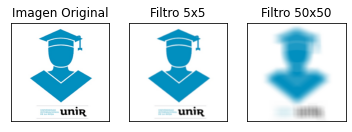

In [6]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out_5 = cv.cvtColor(out_5, cv.COLOR_BGR2RGB)
out_50 = cv.cvtColor(out_50, cv.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(out_5)
plt.title('Filtro 5x5'), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(out_50)
plt.title('Filtro 50x50'), plt.xticks([]), plt.yticks([])
plt.show()

El efecto de limpieza de ruido con este filtro pasa baja (LPF) puede observarse al usarlo con las imágenes guardadas un las variables `image_noisy` e `image_snp`.

In [7]:
# Mantener comentada una de las próximas dos líneas para observar el resultado del filtro
im = image_noisy
#im = image_snp
# Cambie el tamaño de la máscara si así lo desea
kernel = mask(10)
out = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D-cleaning.jpg', out)

True

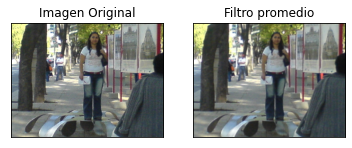

In [8]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro promedio')
plt.xticks([])
plt.yticks([])
plt.show()

Es notorio que este filtro tiene un efecto relativo sobre el ruido: en el caso _sal y pimienta_ limpia muy poco la imagen debido a que se encarga de las anomalías de alta frecuencia (la sal) pero no soluciona las anomalías de baja frecuencia, mientras tanto, en sobre el ruido gausiano la mejora es más notoria. Ahora se procederá a comparar este filtro con otros más y comparar los resultados.

## Filtro gausiano

Los LPF gaussianos se basan en la función de distribución de probabilidad gaussiana. El filtro gaussiano es ampliamente utilizado. Las características de este filtro incluyen:

1. Simetría.
2. Al variar el valor de la desviación estándar, se controla el requisito conflictivo de menos borrosidad y más eliminación de ruido.
3. Los coeficientes caen a niveles insignificantes en los bordes.
4. La transformada de Fourier de una función gaussiana es otra función gaussiana.
5. La convolución de dos funciones gaussianas es otra función gaussiana.

Probarémos este filtro con la imagen almacenada en `image_noisy`, debido a la naturaleza de dicho ruido.

In [9]:
im = image_noisy
# Los parámetros principales son: 1. imagen, 2. Kernel gaussiano (puede ser solo las dimensiones) 3. Desviación estándar.
out = cv.GaussianBlur(im,(9,9),0)
cv.imwrite('out/gaussian-0.jpg', out)

True

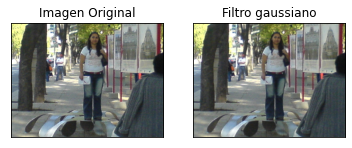

In [10]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro gaussiano')
plt.xticks([])
plt.yticks([])
plt.show()

La función `GaussianBlur()` debe recibir un kernel _nxm_ donde ambos son números impares aunque distintos. En el código mostrado se usa un kernel 9x9 con desviación estándar igual a cero. Bajo estas condiciones el resultado es muy similar al del filtro por promedio, sin embargo, debido al mayor número de parámetros es posible mejorar el resultado si se conserva el kernel y aumenta la desviación estándar. Si este cambio se aplicara a la imagen de control sería claro que el aumento de la desviación estándar incrementa el desenfoque. Por estos motivos, el filtro gausiano es capaz de obtener un resultado optimizado respecto al filtro por promedio.

## Filtro de mediana

El filtrado de mediana permite eliminar valores bajos y altos anómalos, por eso es útil para eliminar el ruido _sal y pimienta_ de la imágen guardada en la variable `image_snp`. Este filtro reemplaza un píxel por la mediana de una máscara de píxeles en su vecindad. Implica clasificar los píxeles de la máscara en orden ascendente o descendente y seleccionar el valor medio, si el número de píxeles es impar.En el caso de una imagen, todas las muestras en la máscara se enumeran como datos 1-D para el cálculo de la mediana, por lo tanto los valores superlativos siempre serán descartados, justo lo que provoca el ruido _sal y pimienta_. Las máscaras de este filtro son comúnmente de tamaño 3x3, 5x5 o 7x7.

In [11]:
im = image_snp
# La función tiene dos parámetros: 1. la imagen, 2. El tamaño de la máscara
out = cv.medianBlur(im,5)
cv.imwrite('out/median-cv.jpg', out)

True

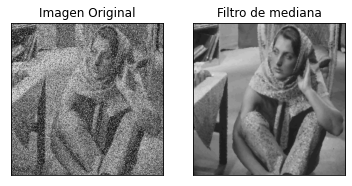

In [12]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro de mediana')
plt.xticks([])
plt.yticks([])
plt.show()

Como puede observarse, este filtro es muy efectivo para eliminar las anomalías, si el tamaño de la máscara comienza a crecer entonces la imagen comienza a sobrecorregir valores.

### Otra implementación

Tanto el filtro de mediana como los vistos anteriormente tienen distintas implementaciones en librerías distintas a OpenCV, por ejemplo Scikit-image. Para este trabajo tomaremos en cuenta una discusión generada a partir de un [código de Github](https://github.com/MeteHanC/Python-Median-Filter/blob/master/MedianFilter.py) y simplificaremos el código con el uso de  [Comprehensions](https://www.python.org/search/?q=comprehensions&submit=), de esta forma el código será sencillo y se podrán incorporar comentarios.

In [13]:
def median_filter(data, filter_size):
    """Apply the median filter.
    
    Arguments:
    data -- An array that represents an image.
    filter_size -- An impair integer that represents mask/window size.
    
    Return a filtered array that represents an image.
    """
    if (filter_size % 2) == 0:
        raise TypeError("filter_size must be an impair integer")
    if not isinstance(data, np.ndarray):
        raise TypeError("data must be an array")
    indexer = filter_size // 2
    mask = [ # Crea un arreglo del tamaño adecuado
        (i, j)
        for i in range(-indexer, filter_size-indexer)
        for j in range(-indexer, filter_size-indexer)
    ]
    index = len(mask) // 2
    # Recorre data
    for i in range(len(data)):
        for j in range(len(data[0])):
            # Ordena data
            data[i][j] = sorted(
                # Será 0 si es un límite de la imagen
                0 if (
                    min(i+a, j+b) < 0
                    or len(data) <= i+a
                    or len(data[0]) <= j+b
                ) else data[i+a][j+b] # De otro modo será el valor de en la imagen
                # Eso lo recorre en cada punto de la máscara
                for a, b in mask
            )[index] # Toma el valor de la mediana una vez ordenada data
    return data

In [14]:
from PIL import Image
# Lectura de la imagen
im = Image.open('im/salt-pepper-1.png')
# Convierte la imagen a un arreglo
input = np.asarray(im)
out = median_filter(input, 3)
Image.fromarray(out).save("out/median-alg.jpg")

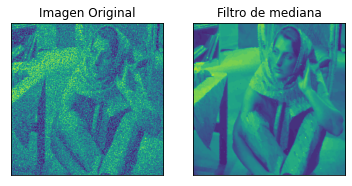

In [15]:
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro de mediana')
plt.xticks([])
plt.yticks([])
plt.show()

Es posible observar que el algoritmo implementado manualmente es más agresivo, con una máscara más pequeña (3x3) se obtiene un resultado similar al de OpenCV con una máscara más grande (5x5). Sin embargo, el algoritmo de OpenCV no deja tantas anomalías evidentes, a diferencia de la implementación manual, donde aún se observan algunas anomalías sal y pimienta.